In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False


data = pd.read_csv('dataset/in_and_out.csv', encoding='cp949')
data.head()

,사용월,호선명,지하철역,04시-05시 승차인원,04시-05시 하차인원,05시-06시 승차인원,05시-06시 하차인원,06시-07시 승차인원,06시-07시 하차인원,07시-08시 승차인원,...,23시-24시 하차인원,00시-01시 승차인원,00시-01시 하차인원,01시-02시 승차인원,01시-02시 하차인원,02시-03시 승차인원,02시-03시 하차인원,03시-04시 승차인원,03시-04시 하차인원,작업일자
0,202504,1호선,동대문,650,26,11355,2005,10238,7181,18411,...,9939,938,3210,3,321,0,0,0,0,20250503
1,202504,1호선,동묘앞,117,3,2844,819,4206,5444,9689,...,4897,120,1996,3,267,0,0,0,0,20250503
2,202504,1호선,서울역,712,48,10654,9668,29272,64058,97455,...,29252,5212,8018,10,262,0,0,0,0,20250503
3,202504,1호선,시청,124,5,2267,5900,3888,28761,7841,...,3763,606,1015,0,15,0,0,0,0,20250503
4,202504,1호선,신설동,381,18,9393,2330,10420,9020,24157,...,9416,455,3039,0,0,1,2,0,0,20250503


C:\Users\kkh01\AppData\Local\Temp\ipykernel_9996\850459830.py:20: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kkh01\AppData\Local\Temp\ipykernel_9996\850459830.py:20: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kkh01\AppData\Local\Temp\ipykernel_9996\850459830.py:20: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kkh01\AppData\Local\Temp\ipykernel_9996\850459830.py:20: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kkh01\AppData\Local\Temp\ipykernel_9996\850459830.py:20: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\kkh01\llll\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from f

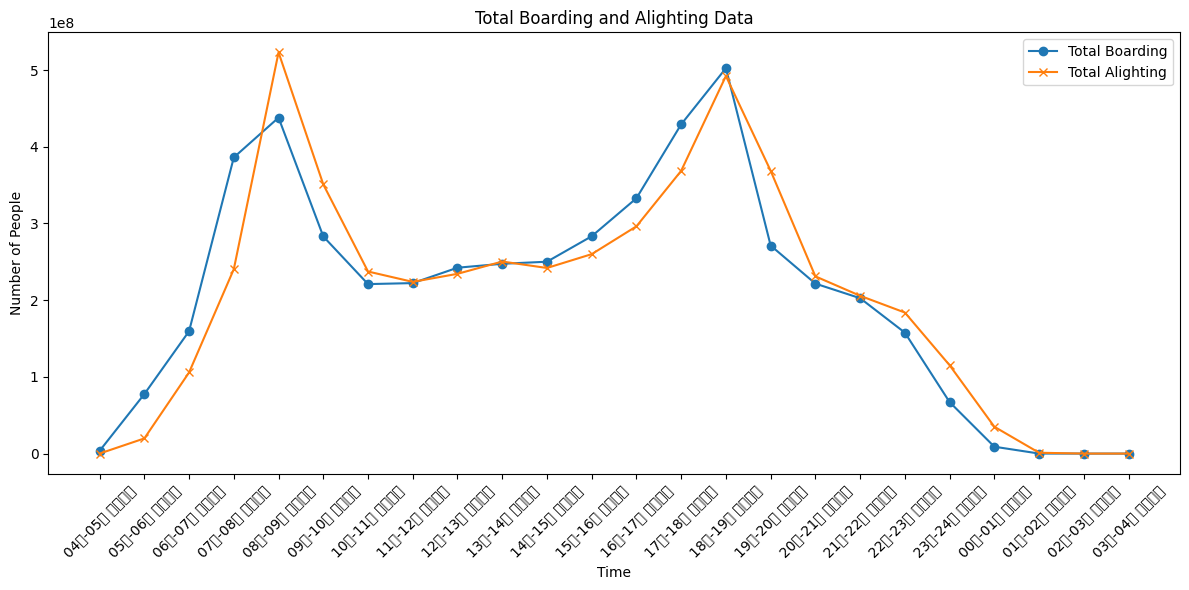

In [2]:
boarding_cols = [col for col in data.columns if '승차인원' in col]
alighting_cols = [col for col in data.columns if '하차인원' in col]

boarding_data = data[boarding_cols].sum(axis=1)
alighting_data = data[alighting_cols].sum(axis=1)

grouped = data.groupby('사용월')

grouped_boarding = grouped[boarding_cols].sum()
grouped_alighting = grouped[alighting_cols].sum()

plt.figure(figsize=(12, 6))
plt.plot(boarding_cols, data[boarding_cols].sum(), label='Total Boarding', marker='o')
plt.plot(boarding_cols, data[alighting_cols].sum(), label='Total Alighting', marker='x')  # x축을 boarding_cols로 통일
plt.title('Total Boarding and Alighting Data')
plt.xlabel('Time')
plt.ylabel('Number of People')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 전처리

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 시간대 컬럼 정렬
time_cols = [col for col in data.columns if '승차' in col or '하차' in col]
# 시간대 추출 및 정렬
def time_sort_key(x):
    h, m = map(int, x.split('-')[0].split('시'))
    return h * 60 + m if m else h * 60
time_order = sorted(set(col.split()[0] for col in time_cols), key=lambda x: int(x[:2])*60+int(x[3:5]))
ordered_cols = []
for t in time_order:
    ordered_cols.append(f'{t} 승차인원')
    ordered_cols.append(f'{t} 하차인원')

# 데이터 정렬
data = data[['사용월', '호선명', '지하철역'] + ordered_cols]

# 월 기준 훈련/테스트 분할
train = data[data['사용월'] < 202501]
test = data[data['사용월'] >= 202501]

# 시계열 입력/타겟 생성 함수
def make_xy(df, window_size=3):
    X, y = [], []
    for _, group in df.groupby(['호선명', '지하철역']):
        vals = group[ordered_cols].values
        # 한 역에 여러 달 데이터가 있을 수 있으니 각 행별로 생성
        for row in vals:
            # 시간대별로 슬라이딩 윈도우
            for i in range(0, len(ordered_cols)//2 - window_size):
                start = i*2
                end = (i+window_size)*2
                X.append(row[start:end])
                y.append(row[end:end+2])
    return np.array(X), np.array(y)

# 입력/타겟 생성
window_size = 3
X_train, y_train = make_xy(train, window_size)
X_test, y_test = make_xy(test, window_size)

# 정규화
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# LSTM 입력 형태로 변환
X_train = X_train.reshape(-1, window_size, 2)
X_test = X_test.reshape(-1, window_size, 2)

# y는 (샘플수, 2) 형태(승차/하차)


# LSTM

Epoch 1/100


c:\Users\kkh01\llll\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6499/6499 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0011 - val_loss: 1.5955e-04
Epoch 2/100
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 6.0407e-04 - val_loss: 1.5896e-04
Epoch 3/100
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 4.6560e-04 - val_loss: 1.1874e-04
Epoch 4/100
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 4.1433e-04 - val_loss: 1.0640e-04
Epoch 5/100
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 3.8546e-04 - val_loss: 1.1198e-04
Epoch 6/100
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 3.6445e-04 - val_loss: 1.0196e-04
Epoch 7/100
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 3.4489e-04 - val_loss: 1.0629e-04
Epoch 8/100
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 3.4691e-04 - val_loss: 9.2447e-05
Epoch 9/100
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 3.3460e-04 - val_loss: 1.0135e-04
Epoch 10/100
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 3.1440e-04 - val_loss: 9.1003e-05
Epoch 11/100
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,896 (226.16 KB)

 Trainable params: 19,298 (75.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,598 (150.78 KB)

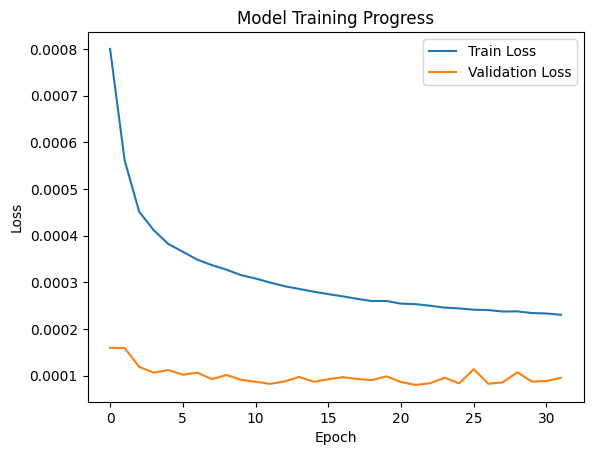

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# LSTM 모델 설계
model = Sequential([
    LSTM(64, input_shape=(3, 2), return_sequences=False),  # 3시간 단위, 승차/하차 2개 특성
    Dense(32, activation='relu'),
    Dense(2)  # 승차/하차 인원 예측 (2개 출력)
])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

model.summary()


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()



# CNN

X_train shape: (259959, 3, 2), y_train shape: (259959, 2)
X_test shape: (52143, 3, 2), y_test shape: (52143, 2)
Epoch 1/30


c:\Users\kkh01\llll\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1016/1016 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0010 - val_loss: 4.7799e-04
Epoch 2/30
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.6351e-04 - val_loss: 3.8271e-04
Epoch 3/30
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.4541e-04 - val_loss: 3.0991e-04
Epoch 4/30
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.9820e-04 - val_loss: 2.8434e-04
Epoch 5/30
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.8482e-04 - val_loss: 2.7502e-04
Epoch 6/30
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.5910e-04 - val_loss: 2.6242e-04
Epoch 7/30
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.5443e-04 - val_loss: 2.4380e-04
Epoch 8/30
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.4308e-04 - val_loss: 2.5398e-04
Epoch 9/30
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.3525e-04 - val_loss: 2.3849e-04
Epoch 10/30
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.2756e-04 - val_loss: 2.3971e-04
Epoch 11/30
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

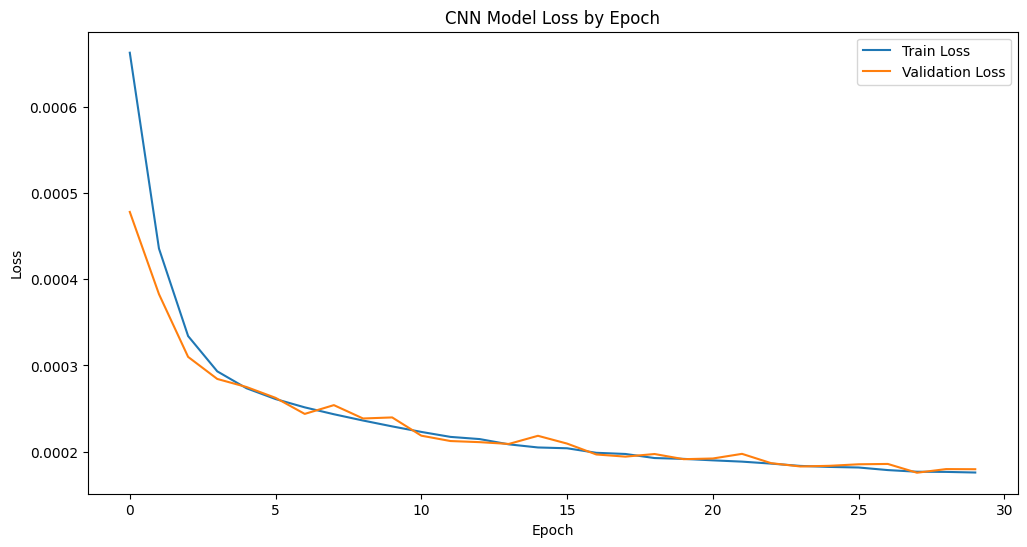

In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# 1. 시간대 컬럼 정렬
time_cols = [col for col in data.columns if '승차' in col or '하차' in col]
time_order = sorted(set(col.split()[0] for col in time_cols), key=lambda x: int(x[:2])*60 + int(x[3:5]))
ordered_cols = []
for t in time_order:
    ordered_cols.append(f'{t} 승차인원')
    ordered_cols.append(f'{t} 하차인원')

data = data[['사용월', '호선명', '지하철역'] + ordered_cols]

# 2. 훈련/테스트 분할
train = data[data['사용월'] < 202501]
test = data[data['사용월'] >= 202501]

# 3. 슬라이딩 윈도우 방식 데이터 생성 (역/호선별 그룹)
def make_ml_data(df, window_size=3):
    X, y = [], []
    for _, group in df.groupby(['호선명', '지하철역']):
        vals = group[ordered_cols].values
        for row in vals:
            for i in range(0, len(ordered_cols)//2 - window_size):
                start = i*2
                end = (i+window_size)*2
                X.append(row[start:end])
                y.append(row[end:end+2])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(-1, window_size, 2)
    return X, y

window_size = 3
X_train, y_train = make_ml_data(train, window_size)
X_test, y_test = make_ml_data(test, window_size)

# 4. 정규화
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train.reshape(-1, window_size*2)).reshape(-1, window_size, 2)
X_test = scaler_X.transform(X_test.reshape(-1, window_size*2)).reshape(-1, window_size, 2)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# 5. Keras CNN 모델 정의
model = Sequential([
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(window_size, 2)),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2)
])

model.compile(optimizer=Adam(0.0005), loss='mse')

# 6. 학습
# 모델 학습 시 반환된 history 객체를 사용
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=256,
    validation_data=(X_test, y_test)
)

# 7. 예측 및 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'CNN Test MSE: {mse:.2f}, R2: {r2:.2f}')



# y_test, y_pred는 정규화된 상태입니다.

plt.figure(figsize=(12, 6))

# 손실 곡선 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


Epoch 1/30


c:\Users\kkh01\llll\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1625/1625 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0015 - val_loss: 1.6315e-04
Epoch 2/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7.5750e-04 - val_loss: 1.3321e-04
Epoch 3/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.7442e-04 - val_loss: 1.3440e-04
Epoch 4/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.5385e-04 - val_loss: 1.2784e-04
Epoch 5/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.8093e-04 - val_loss: 1.2779e-04
Epoch 6/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.2105e-04 - val_loss: 1.2062e-04
Epoch 7/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.7701e-04 - val_loss: 1.0819e-04
Epoch 8/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.6230e-04 - val_loss: 9.9817e-05
Epoch 9/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.4566e-04 - val_loss: 1.0888e-04
Epoch 10/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.2428e-04 - val_loss: 1.0600e-04
Epoch 11/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

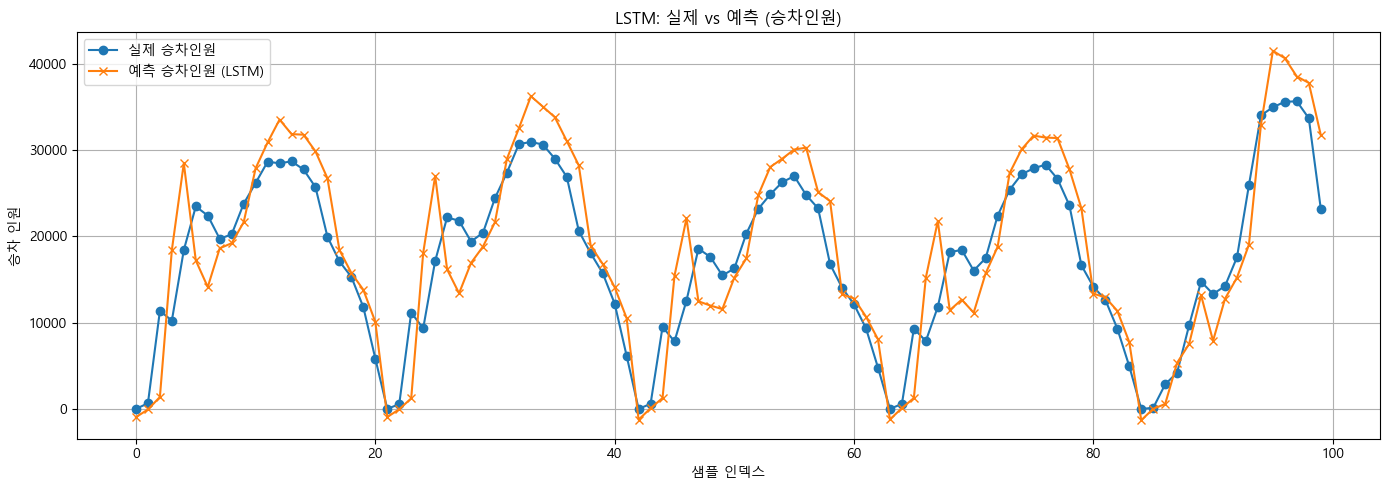

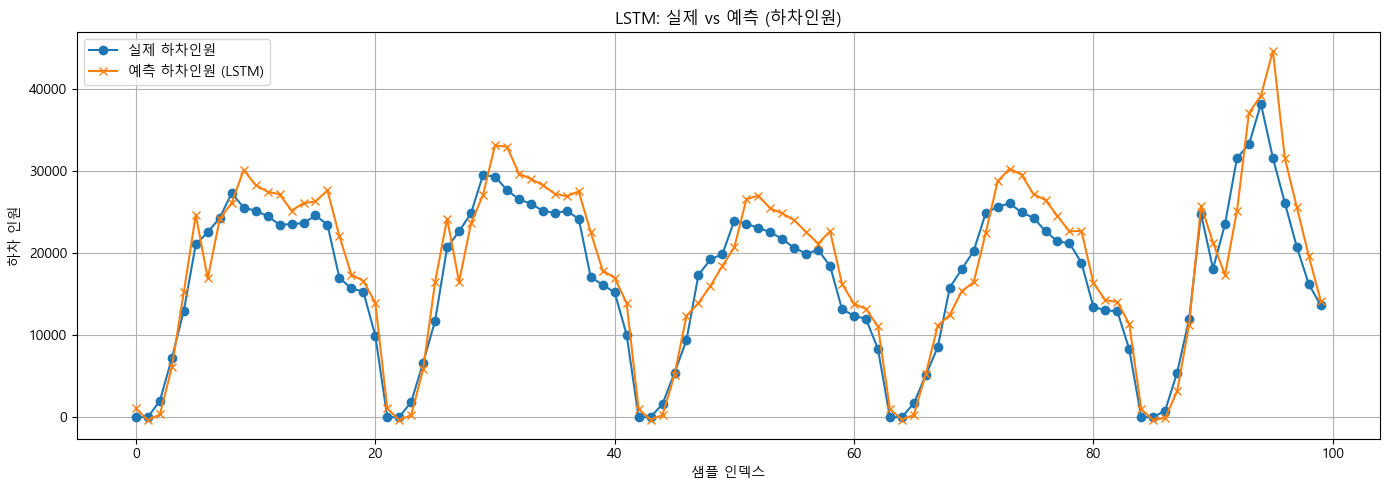

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# 1. LSTM 모델 정의
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(2)  # 승차, 하차 동시 예측
])
model.compile(optimizer='adam', loss='mse')

# 2. 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

# 3. 예측 및 역정규화
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# 4. 시각화 (승차/하차 분리)
num_samples = 100

# 승차인원
plt.figure(figsize=(14,5))
plt.plot(range(num_samples), y_test_inv[:num_samples, 0], label='실제 승차인원', marker='o')
plt.plot(range(num_samples), y_pred_inv[:num_samples, 0], label='예측 승차인원 (LSTM)', marker='x')
plt.title('LSTM: 실제 vs 예측 (승차인원)')
plt.xlabel('샘플 인덱스')
plt.ylabel('승차 인원')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 하차인원
plt.figure(figsize=(14,5))
plt.plot(range(num_samples), y_test_inv[:num_samples, 1], label='실제 하차인원', marker='o')
plt.plot(range(num_samples), y_pred_inv[:num_samples, 1], label='예측 하차인원 (LSTM)', marker='x')
plt.title('LSTM: 실제 vs 예측 (하차인원)')
plt.xlabel('샘플 인덱스')
plt.ylabel('하차 인원')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
